<a href="https://colab.research.google.com/github/hero-hub/cnn_psf/blob/main/cnn_resnet_2layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# ======================
# 1. Импорт библиотек
# ======================
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile
from google.colab import drive
import sys

In [15]:
# ======================
# 2. Загрузка и подготовка данных
# ======================
# Подключение Google Drive
drive.mount('/content/drive')

# Путь к папке, где находится library_help_tools.py
sys.path.insert(0, '/content/drive/My Drive/Colab_Notebooks/scripts')

# Проверка, что путь добавлен
print(sys.path)

try:
    import library_help_tools as lht
    print("Модуль успешно импортирован!")
except ModuleNotFoundError as e:
    print(f"Ошибка импорта: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/My Drive/Colab_Notebooks/scripts', '/content/drive/My Drive/Colab_Notebooks/scripts', '/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor']
Модуль успешно импортирован!


In [17]:
dir_test = '../data/PSF_PNG/PSF_Test36/'
dir_ast3_spher35 = '../data/PSF_PNG/PSF_Ast3_Spher35/'
zip_file = '/content/drive/My Drive/Colab_Notebooks/img128_6194.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

def load_images_from_directory(dir_read):
    images = []  # Список для хранения изображений
    list_file = os.listdir(dir_read)  # Получаем список файлов в директории

    for cur_file in list_file:
        cur_file_path = os.path.join(dir_read, cur_file)
        try:
            img = Image.open(cur_file_path)  # Читаем изображение
            images.append(img)  # Добавляем изображение в список
        except Exception as e:
            print(f"Ошибка при чтении файла {cur_file_path}: {e}")

    print(f'Количество загруженных изображений - {len(images)}')
    return images

zip_directory = 'img128_6194/'  # Директория с распакованными изображениями
images = load_images_from_directory(zip_directory)  # Загружаем изображения

['.config', 'img128_2986', 'img128_6194', 'drive', 'sample_data']
Количество загруженных изображений - 6194


In [18]:
# Создаем словарь с параметрами
GVD = dict(
    DATA_DIR = zip_directory,
    FILE_FORMAT = ".png",
    IMG_SIZE = 128,
    TEST_SPLIT = 0.2,
    VALIDATION_SPLIT = 0.2,
    SEED = 123
)

In [19]:
# Загрузка данных
ts_images, ts_labels = lht.load_data(lht.list_files(GVD['DATA_DIR'], GVD['FILE_FORMAT']))

# Преобразование в numpy массивы, если это еще не сделано
ts_images = np.array(ts_images)
ts_labels = np.array(ts_labels)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    ts_images, ts_labels, test_size=0.2, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Преобразование в tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [20]:
# ======================
# 3. Создание модели
# ======================
import tensorflow as tf
from tensorflow.keras import layers, models  # Добавьте этот импорт
from tensorflow.keras.applications import ResNet50

# Входной слой
inputs = layers.Input(shape=(128, 128, 1))  #128x128 и ЧБ (1 канал)

# Предварительные сверточные слои
x = layers.Conv2D(64, 3, activation='gelu', padding='same')(inputs)
x = layers.Conv2D(128, 5, activation='gelu', padding='same')(x)

# ResNet50 (без вершинных слоев)
resnet = ResNet50(
    include_top=False,
    weights=None,
    input_tensor=x,  # Передаем выход предыдущего слоя
    pooling='avg'  # Глобальное усреднение
)

# Выходной слой для регрессии (2 выхода: x и y)
outputs = layers.Dense(2, activation='linear')(resnet.output)

# Создание модели
model = models.Model(inputs=inputs, outputs=outputs)

# Вывод структуры модели (для проверки)
#model.summary()

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae')
    ]
)

In [21]:
# ======================
# 4. Обучение модели
# ======================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_rmse')
    ]
)

Epoch 1/12
124/124 ━━━━━━━━━━━━━━━━━━━━ 136s 633ms/step - loss: 666.3933 - mae: 14.8371 - rmse: 22.8969 - val_loss: 453.6178 - val_mae: 17.2609 - val_rmse: 21.2983
Epoch 2/12
124/124 ━━━━━━━━━━━━━━━━━━━━ 33s 264ms/step - loss: 6.5127 - mae: 1.9901 - rmse: 2.4984 - val_loss: 378.1220 - val_mae: 15.8493 - val_rmse: 19.4454
Epoch 3/12
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - loss: 3.3737 - mae: 1.4915 - rmse: 1.8327 - val_loss: 245.1355 - val_mae: 13.0560 - val_rmse: 15.6568
Epoch 4/12
124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 261ms/step - loss: 4.5377 - mae: 1.6250 - rmse: 2.1198 - val_loss: 62.5264 - val_mae: 6.2979 - val_rmse: 7.9074
Epoch 5/12
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 263ms/step - loss: 2.4228 - mae: 1.2467 - rmse: 1.5423 - val_loss: 4.9925 - val_mae: 1.8600 - val_rmse: 2.2344
Epoch 6/12
124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 261ms/step - loss: 2.1524 - mae: 1.1637 - rmse: 1.4566 - val_loss: 8.3607 - val_mae: 2.7050 - val_rmse: 2.8915
Epoch 7/12
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/st


Ошибки на тестовом наборе:
RMSE: 0.48 пикселей
Максимальная ошибка: 0.41 пикселей


KeyError: 'max_error_px'

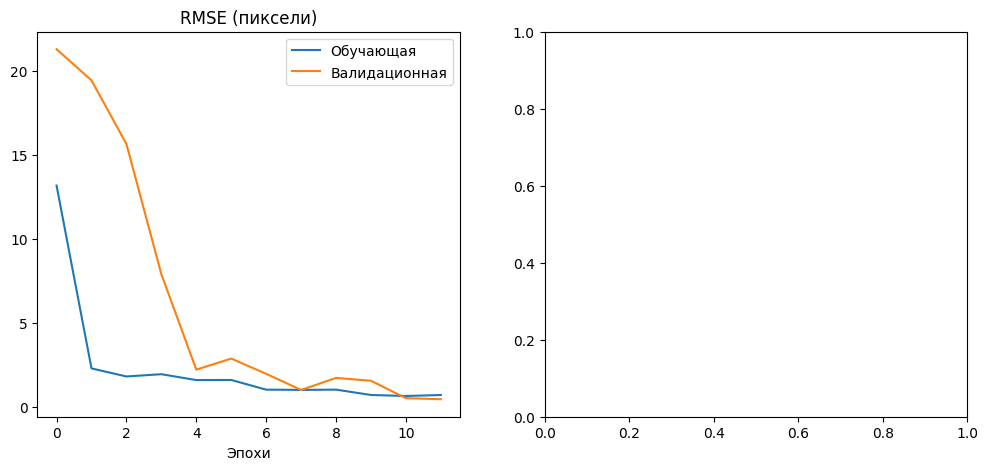

In [22]:
# ======================
# 5. Оценка и визуализация
# ======================
# Оценка на тестовом наборе
test_loss, test_rmse, test_max_error = model.evaluate(test_ds, verbose=0)
print(f"\nОшибки на тестовом наборе:")
print(f"RMSE: {test_rmse:.2f} пикселей")
print(f"Максимальная ошибка: {test_max_error:.2f} пикселей")

# Визуализация обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['rmse'], label='Обучающая')
plt.plot(history.history['val_rmse'], label='Тестовая')
plt.title('RMSE (пиксели)')
plt.xlabel('Эпохи')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['max_error_px'], label='Обучающая')
plt.plot(history.history['val_max_error_px'], label='Тестовая')
plt.title('Максимальная ошибка (пиксели)')
plt.xlabel('Эпохи')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


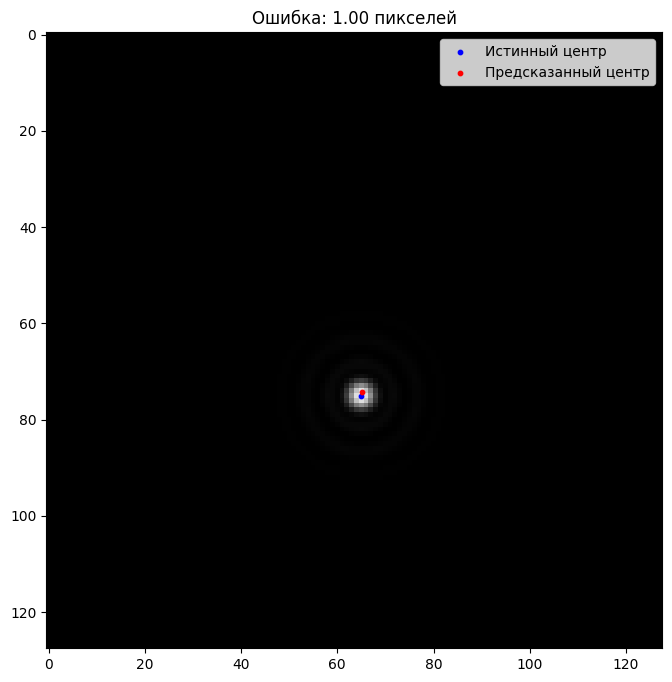

In [23]:
# ======================
# 6. Визуализация предсказания
# ======================
# Берем одно изображение из тестового набора
sample_image, true_center = next(iter(test_ds))
predicted_center = model.predict(sample_image[0:1])[0]

# Отображение результата
plt.figure(figsize=(8, 8))
plt.imshow(sample_image[0].numpy().squeeze(), cmap='gray')
plt.scatter(true_center[0][1], true_center[0][0], c='blue', s=10, label='Истинный центр')
plt.scatter(predicted_center[1], predicted_center[0], c='red', s=10, label='Предсказанный центр')
plt.title(f"Ошибка: {np.linalg.norm(true_center[0] - predicted_center):.2f} пикселей")
plt.legend()
plt.show()